<h1><center> BioE245 Final project Part1: Lower-dimension representations of the cells </h1></center>
<h2><center> Efficacy Comparison in term of clustering of AutoEncoder, PCA, tSNE for 2D representation of Peripheral blood mononuclear cells using transcriptomics data  </h2></center>
    
## Hugo Hakem Meng BioE 23-24'

### Acknowledgement
This work stands as the final project for the BioE245 class taught in Spring2024 by Professor. Liana Lareau, and GSIs. Michael Herschl, Amy Lu.

# 0) Some background and motivation
Peripheral blood mononuclear cells (PBMCs) are a group of different cell types in your blood, a subset of what we call white blood cells. They include many important parts of your immune system: T cells, B cells, natural killer cells, and so on. These cells are responsible for your innate and adaptive immune responses. When you get infected or vaccinated, they kick into high gear. In different situations, or with different diseases, the mix of different cell types shifts and so does the gene expression within one type of cell. PBMCs can be isolated very easily from patient blood samples, just by spinning the blood in a centrifuge that separates different cell types by weight. So, looking at these cells can be very informative.

For this present work, two dataset has been furnished: 
+ labels.csv stores the association between a cell barcode and a cell type label.
+ processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.
    
The goal of this part of the project is to represent PBMC cells onto a 2D plot and compare the different dimensionality reduction method. 

This Notebook is partitionned as follow.
1. [Data Preprocessing](#PrePro)
2. [Model Implementation](#Model)
    1. [AutoEncoder Architecture](#AutoEncoder)
    2. [Trainer](#Trainer)
3. [2D Representation](#2Dplot)
    1. [AutoEncoder - Fine Tuning](#FineTune)
    2. [Method Comparison](#Comparison)
4. [Conclusion](#Conclusion)


To run the present Notebook, here is a list of command to run sequentially in your environment and which will install the package required. 

```conda install ipykernel conda-forge -y```
```conda install pytorch torchvision torchaudio pytorch-cuda=11.8 -c pytorch -c nvidia```
```conda install pandas matplotlib seaborn tqdm -c conda-forge -y```
    
**Please Note: for each model recquiring some fine-tuning, several parameters has been tested and only the best architecture are displayed** 
    
# 1) Data Preprocessing <a id="PrePro"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 

from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

This data associates a cell barcode, such as "AAAGCCTGGCTAAC-1", to a certain cell type label, such as "CD14+ Monocyte". For each cell barcode, there are also log RNA seq counts of 765 different genes, such as HES4.

label.csv stores the association between a cell barcode and a cell type label.

processed_counts.csv stores the normalized log read counts for each cell, where each row represents a single cell, and each column represents a gene.

In [2]:
labels_pd = pd.read_csv("labels.csv")
counts_pd = pd.read_csv("processed_counts.csv")

In [3]:
print(f"Numb unique labels: {len(labels_pd.bulk_labels.unique())}")
labels_pd

Numb unique labels: 10


,index,bulk_labels
0,AAAGCCTGGCTAAC-1,CD14+ Monocyte
1,AAATTCGATGCACA-1,Dendritic
2,AACACGTGGTCTTT-1,CD56+ NK
3,AAGTGCACGTGCTA-1,CD4+/CD25 T Reg
4,ACACGAACGGAGTG-1,Dendritic
...,...,...
695,TGGCACCTCCAACA-8,Dendritic
696,TGTGAGTGCTTTAC-8,Dendritic
697,TGTTACTGGCGATT-8,CD4+/CD25 T Reg
698,TTCAGTACCGGGAA-8,CD19+ B


In [4]:
print(f"Numb input dim: {counts_pd.shape[1]-1}")
counts_pd

Numb input dim: 765


,Unnamed: 0,HES4,TNFRSF4,SSU72,PARK7,RBP7,SRM,MAD2L2,AGTRAP,TNFRSF1B,...,ATP5O,MRPS6,TTC3,U2AF1,CSTB,SUMO3,ITGB2,S100B,PRMT2,MT-ND3
0,AAAGCCTGGCTAAC-1,-0.326,-0.191,-0.728,-0.301,3.386,-0.531,2.016,3.377,4.841,...,-0.146,-0.532,-0.341,0.303,1.404,4.294,0.519,-0.21,-0.636,4.011
1,AAATTCGATGCACA-1,1.171,-0.191,0.795,-1.200,-0.174,-0.531,1.889,-0.486,-0.459,...,-1.136,-0.532,-0.341,-0.905,2.849,-0.585,1.172,-0.21,2.630,-0.490
2,AACACGTGGTCTTT-1,-0.326,-0.191,0.483,-1.200,-0.174,-0.531,-0.451,0.971,-0.459,...,-1.136,2.606,-0.341,-0.905,-0.455,-0.585,0.722,-0.21,0.663,-0.490
3,AAGTGCACGTGCTA-1,-0.326,-0.191,1.134,-0.157,-0.174,-0.531,-0.451,-0.486,-0.459,...,1.161,-0.532,-0.341,-0.905,-0.119,-0.585,0.766,-0.21,-0.636,-0.490
4,ACACGAACGGAGTG-1,-0.326,-0.191,-0.728,-0.607,-0.174,-0.531,-0.451,0.787,-0.459,...,-1.136,0.839,1.679,-0.108,-0.534,-0.585,-0.007,-0.21,-0.636,-0.490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,TGGCACCTCCAACA-8,-0.326,-0.191,0.372,-0.584,-0.174,0.509,-0.451,2.160,-0.459,...,1.576,-0.532,1.758,1.578,0.055,-0.585,0.561,-0.21,0.543,2.593
696,TGTGAGTGCTTTAC-8,3.166,-0.191,-0.728,-1.200,-0.174,-0.531,-0.451,-0.486,-0.459,...,-1.136,-0.532,-0.341,0.432,0.753,-0.585,-0.171,-0.21,1.268,-0.490
697,TGTTACTGGCGATT-8,-0.326,-0.191,-0.728,-1.200,-0.174,1.784,-0.451,-0.486,-0.459,...,-0.381,-0.532,-0.341,1.858,0.814,-0.585,0.152,-0.21,-0.636,1.226
698,TTCAGTACCGGGAA-8,-0.326,-0.191,-0.728,-0.386,-0.174,-0.531,-0.451,-0.486,-0.459,...,-1.136,-0.532,-0.341,2.378,0.420,0.888,-0.326,-0.21,-0.636,-0.490


In [5]:
#Enable the use of cuda if run with a GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

+ **labels and the counts are shuffled together.**

+ **A split into train and test sets (80:20 split) is performed.**

In [7]:
X = torch.tensor(np.array(counts_pd.values[:,1:], dtype=np.float64), dtype=torch.float).to(device)
y = np.array(labels_pd.values[:,1])

np.random.seed(100)
permutation = np.random.permutation(len(X))
X, y = X[permutation], y[permutation]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

To create a Autoencoder, the number of neurons in each hidden layer need to be determined. I have chosen to partition the input feature by 2 until reaching a latent space of 32. 

In [10]:
def Divper2(numb):
    """
    Return a list the successive numb divided by 2 until reaching 1.
    
    Parameter
    ---------
    numb(int)
    
    Output
    ------
    res(list(int))
    """
    res = []
    red_numb = numb
    while red_numb != 0:
        res.append(red_numb)
        red_numb = red_numb//2
    return res
Divper2(765)

[765, 382, 191, 95, 47, 23, 11, 5, 2, 1]

**Project Recquirement** 

Create a fully connected neural network for your autoencoder. Your latent space can be of any size less than or equal to 64. Too large may result in a poor visualization, and too small may result in high loss. 32 is a good starting point.

Consider using more than 1 hidden layer, and a sparcity constraint (l1 regularization).

Have an encoder model which is a model of only the layers for the encoding.

# 2) Model Implementation <a id="Model"></a>
## A) AutoEncoder Architecture <a id="AutoEncoder"></a>

This AutoEncoder architecture is as follow: 
Base unit repeated $n-2$ times, by providing a list $[n_1,...n_n]$: 

For $i$ in $[1,...,n-2]$
+ $Linear(n_i,n_{i+1})$
+ $ReLU()$

Then feed to the output layer: 
+ $Linear(n_{n-1},n_n)$

The Decoder is the exact reverse of the AutoEncoder:

For $i$ in $[n,...,2]$
+ $Linear(n_{i},n_{i-1})$
+ $ReLU()$

Then feed to the output layer: 
+ $Linear(n_2,n_1)$

In particular, $(n_1, n_n)$ must respectively be the **input feature number** and **Embedded dimension wished**, which are here **765** and **32**.

In [11]:
class AutoEncoder(nn.Module):
    def __init__(self, list_emb_dim):
        super().__init__()
        self.encod_dim = list_emb_dim
        self.decod_dim = np.flip(list_emb_dim)
        self.autoencode_layers = [[nn.Linear(self.encod_dim[i], self.encod_dim[i+1]), nn.ReLU()] for i in range(len(self.encod_dim)-1)]
        self.autoencoder = nn.Sequential(*[layer for layers in self.autoencode_layers for layer in layers])
        self.decoder_layers = [[nn.Linear(self.decod_dim[i], self.decod_dim[i+1]), nn.ReLU()] for i in range(len(self.decod_dim)-2)]
        self.decoder = nn.Sequential(*[layer for layers in self.decoder_layers for layer in layers])
        self.out = nn.Linear(self.decod_dim[-2], self.decod_dim[-1])

    def forward(self, X):
        X_emb = self.autoencoder(X)
        decod = self.decoder(X_emb)
        return self.out(decod)

    def Encoder(self, X):
        return self.autoencoder(X)

**Project Recquirement** 

Train your autoencoding using MSE loss.

Finally, identify the parameters which don't overfit, and use the same model architecture and train on all of the data together.

With a latent space size of 32, aim for 0.9 MSE loss on your test set, 0.95 with regularization. You will not be graded strictly on a loss cutoff.

## B) Trainer <a id="Trainer"></a>

In [12]:
class AutoEncoderTrainer:
    '''
    Model trainer
    '''
    def __init__(self, model, batch_size, learning_rate, epoch, l1=0, l2=0):

        '''
        Initialization 

        Parameters
        ----------
        model(Pytorch model): model to be trained
        batch_size(int): size of the batch to use for GraphDataLoader
        learning_rate(float): learning rate for the optimiser Adam
        epoch(int): The number of training roung to achieve
        l1(bool): l1 regularization of the loss to reduce overfitting
        '''
        self.model = model

        num_params = sum(item.numel() for item in model.parameters())
        #print(f"{model.__class__.__name__} - Number of parameters: {num_params}")

        self.batch_size = batch_size
        self.optimizer = torch.optim.Adam(self.model.parameters(), learning_rate, weight_decay=l2)
        self.loss = nn.MSELoss()
        self.epoch = epoch
        self.l1 = l1

    def train(self, train_dataset, test_dataset, draw_curve=True, early_stop=True):
        loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False)

        train_loss_all = []
        test_loss_all = []
        train_loss_min = np.inf
        test_loss_kept = np.inf
        
        for i in tqdm(range(self.epoch), leave=True):
            epoch_loss = 0
            self.model.train()
            for batch_data in loader:
                
                batch_pred = self.model(batch_data)
                
                # L1 regularisation
                batch_loss = self.loss(batch_pred, batch_data) + self.l1 * torch.norm(torch.cat([x.view(-1) for x in self.model.parameters()]), 1)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                epoch_loss += batch_loss.detach().cpu().numpy() * batch_data.shape[0]/train_dataset.shape[0]
                
            train_loss_all.append(epoch_loss)
            test_loss_all.append(self.evaluate(test_dataset))
            
            if early_stop:
                if train_loss_all[-1] < train_loss_min:
                    train_loss_min = train_loss_all[-1]
                    test_loss_kept = test_loss_all[-1]
                    weights = self.model.state_dict()
                    
        if early_stop:
            self.model.load_state_dict(weights)
            
        if draw_curve:
            if early_stop:
                index = np.argmin(train_loss_all)
            else:
                index = self.epoch - 1
            fig, ax = plt.subplots(1, 1, figsize=(14, 8), constrained_layout=True)
            ax.set_title("Training vs Test Loss per Epochs", fontsize=20)
            ax.plot(np.arange(len(train_loss_all)), train_loss_all, label='train', color='b')
            ax.plot(np.arange(len(test_loss_all)), test_loss_all, label='test', color='r')
            ax.set_xlabel("# Epochs", fontsize=20)
            ax.set_ylabel("Loss", fontsize=20)
            ax.legend()
            ax.scatter(index, train_loss_all[index], c='b')
            ax.scatter(index, test_loss_all[index], c='r')
            ax.annotate(f"{train_loss_all[index]:0.03f}", (index, train_loss_all[index]), fontsize=15)
            ax.annotate(f"{test_loss_all[index]:0.03f}", (index, test_loss_all[index]), fontsize=15)
            return train_loss_all, test_loss_all, self.model
            
        else:
            return train_loss_min, test_loss_kept, self.model

    def evaluate(self, test_dataset):
        self.model.eval()
        with torch.no_grad():
            test_pred = self.model(test_dataset)
            test_loss = self.loss(test_pred, test_dataset) + self.l1 * torch.norm(torch.cat([x.view(-1) for x in model.parameters()]), 1)
        return test_loss.detach().cpu().numpy()

100%|██████████| 30/30 [00:01<00:00, 21.38it/s]


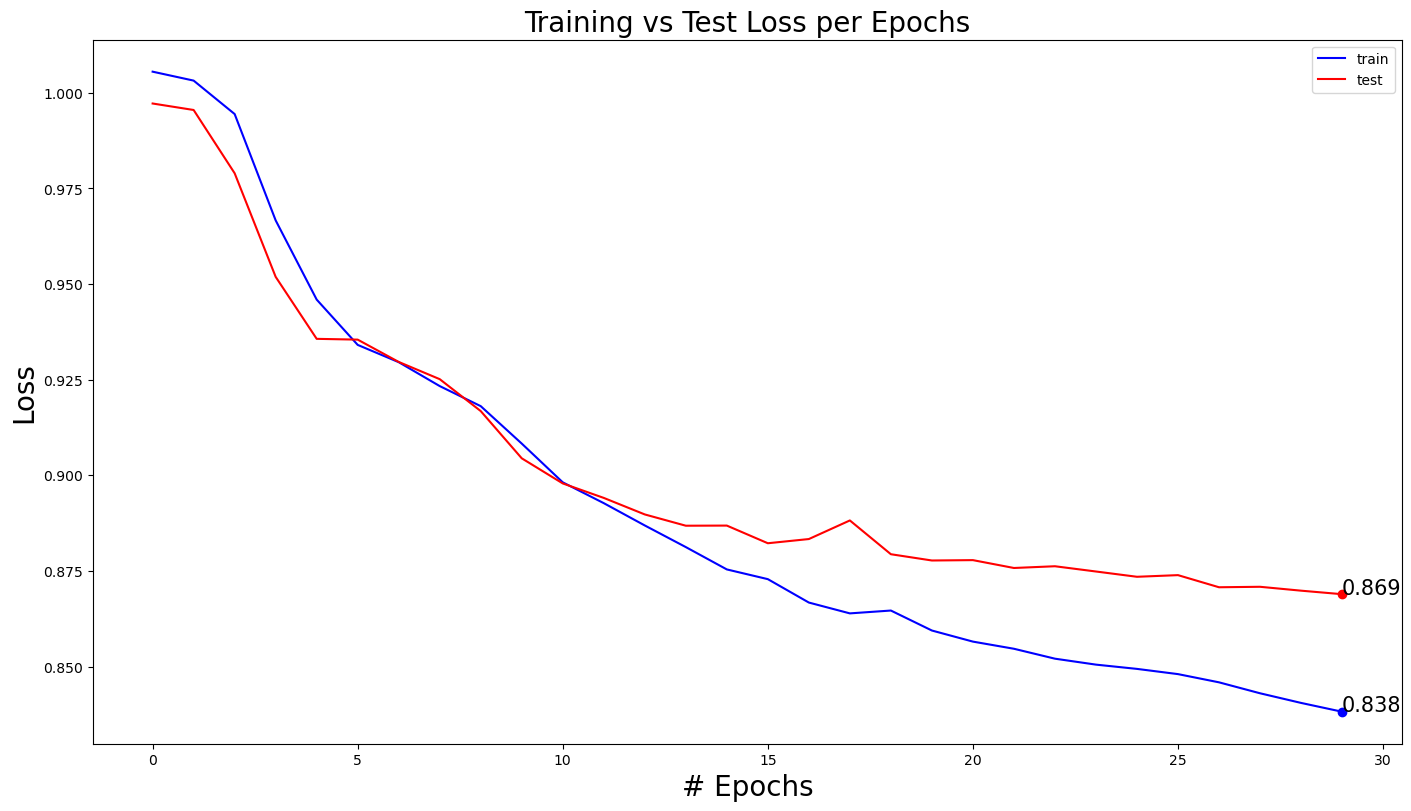

In [14]:
model = AutoEncoder([765, 512, 256, 128, 64, 32]) #[765, 382, 191, 95, 32]
model = model.to(device)
Trainer = AutoEncoderTrainer(model, batch_size=100, learning_rate=1e-3, epoch=30, l1=0, l2=0)
train_loss_all, test_loss_all, model_trained = Trainer.train(X_train, X_test, draw_curve=True, early_stop=True)

100%|██████████| 30/30 [00:01<00:00, 22.57it/s]


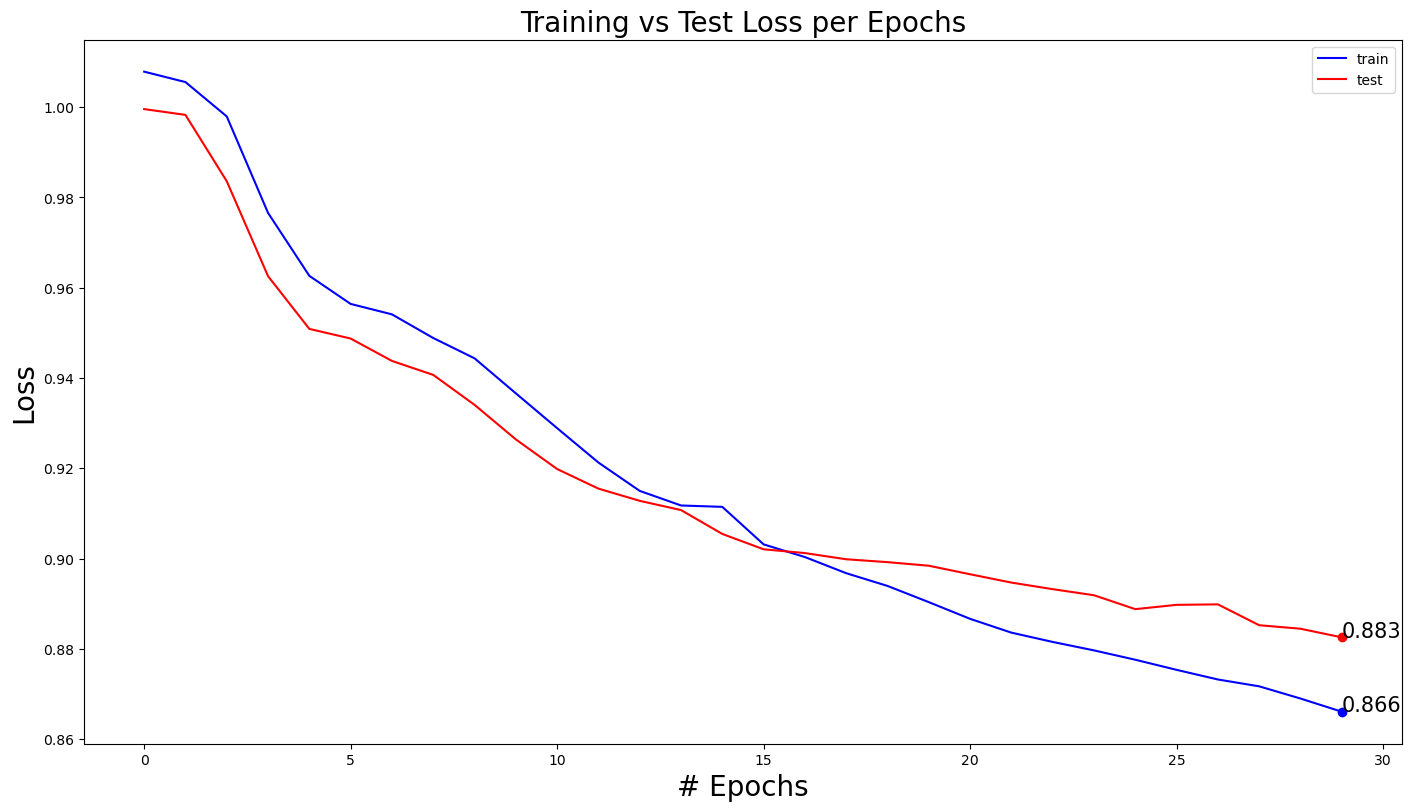

In [51]:
model = AutoEncoder([765, 512, 256, 128, 64, 32])#[765, 382, 191, 95, 32])
model = model.to(device)
Trainer = AutoEncoderTrainer(model, batch_size=100, learning_rate=1e-3, epoch=30, l1=1e-7, l2=0)
train_loss_all, test_loss_all, model_trained = Trainer.train(X_train, X_test, draw_curve=True, early_stop=True)

100%|██████████| 30/30 [00:01<00:00, 18.35it/s]


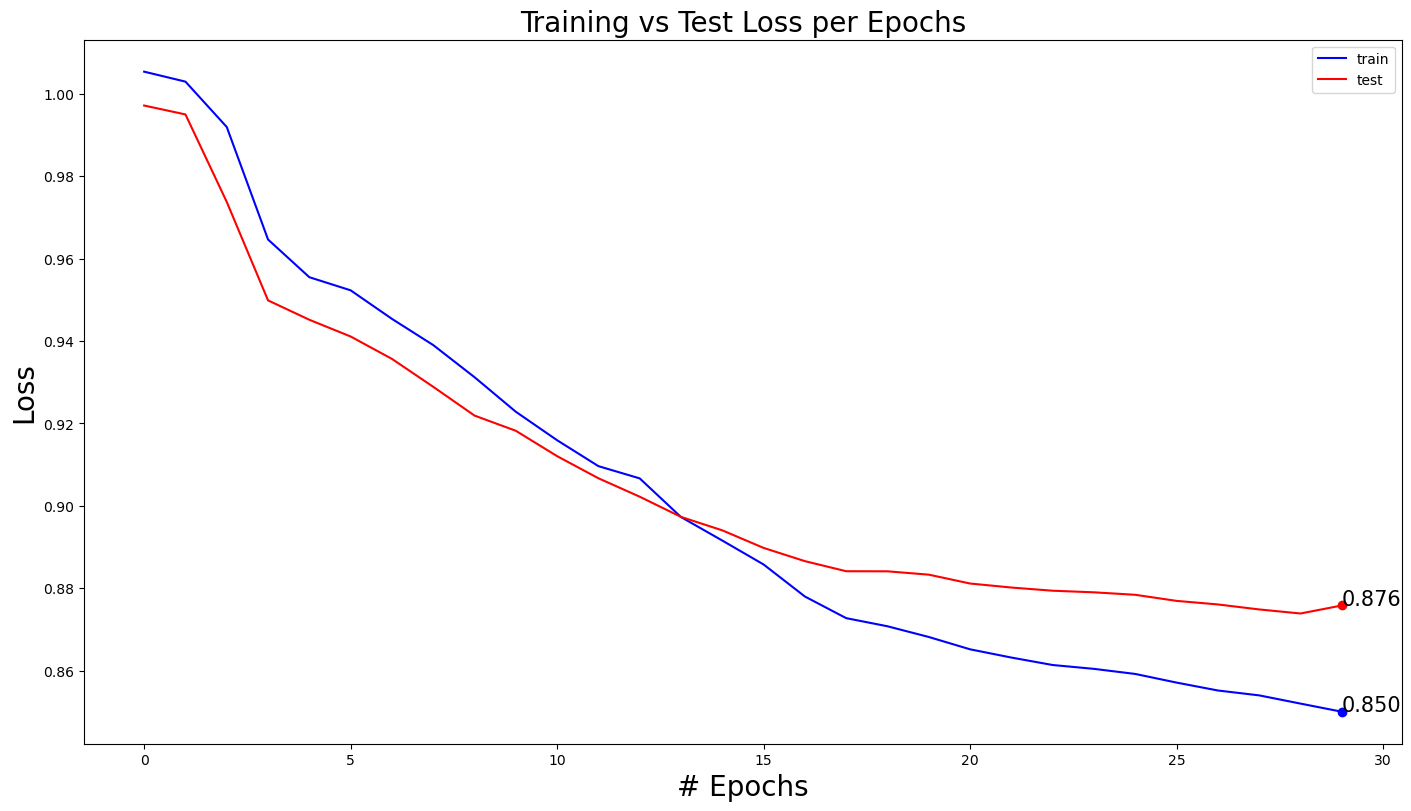

In [53]:
model = AutoEncoder([765, 512, 256, 128, 64, 32])#[765, 382, 191, 95, 32])
model = model.to(device)
Trainer = AutoEncoderTrainer(model, batch_size=100, learning_rate=1e-3, epoch=30, l1=0, l2=1e-6)
train_loss_all, test_loss_all, model_trained = Trainer.train(X_train, X_test, draw_curve=True, early_stop=True)

Using a l1 or l2 regularisation lead to an important decrease of over-fitting. 

# 3) 2D Representation <a id="2Dplot"></a>
## A) AutoEncoder - Fine Tuning <a id="FineTune"></a>

The Fine-tuning of the AutoEncoder is difficult if we only base our judgement on the loss reached. Let's therefore plot in 2D the result of each AutoEncoder and see which tuple of **l1, l2** penalty leads to the best clustering.    

In [16]:
def plot2D(X, y, ax, title, legend=False):
    """
    Create a 2D plot
    
    Parameters
    ----------
    X(array): shape(n_samples, 2) The coordinate of each dot.
    y(array): shape(n_samples,) The label of each dot
    title(string): title to use
    legend(bool): whether to show the legend
    """
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=y,
                    palette=sns.color_palette("hls", len(np.unique(y))),
                    legend="full",
                    alpha=0.75,
                    ax=ax)
    ax.set_title(title)
    if legend == False:
        ax.get_legend().remove()

In [17]:
def power_list(numb, start):
    """
    Create a list of [0, 1e-(start), ..., 1e-(start+numb-2)]
    
    Parameters
    ----------
    numb(int)
    start(int)
    """
    return [0] + [float(f"1e-{start+i}") for i in range(numb-1)]

In [54]:
power_list(7, 7)

[0, 1e-07, 1e-08, 1e-09, 1e-10, 1e-11, 1e-12]

For **ease of visualisation**, no legend is plotted on each plot.
Let's sweep which penalty **l1,l2** is best in term of clustering.  

100%|██████████| 30/30 [00:01<00:00, 20.41it/s]


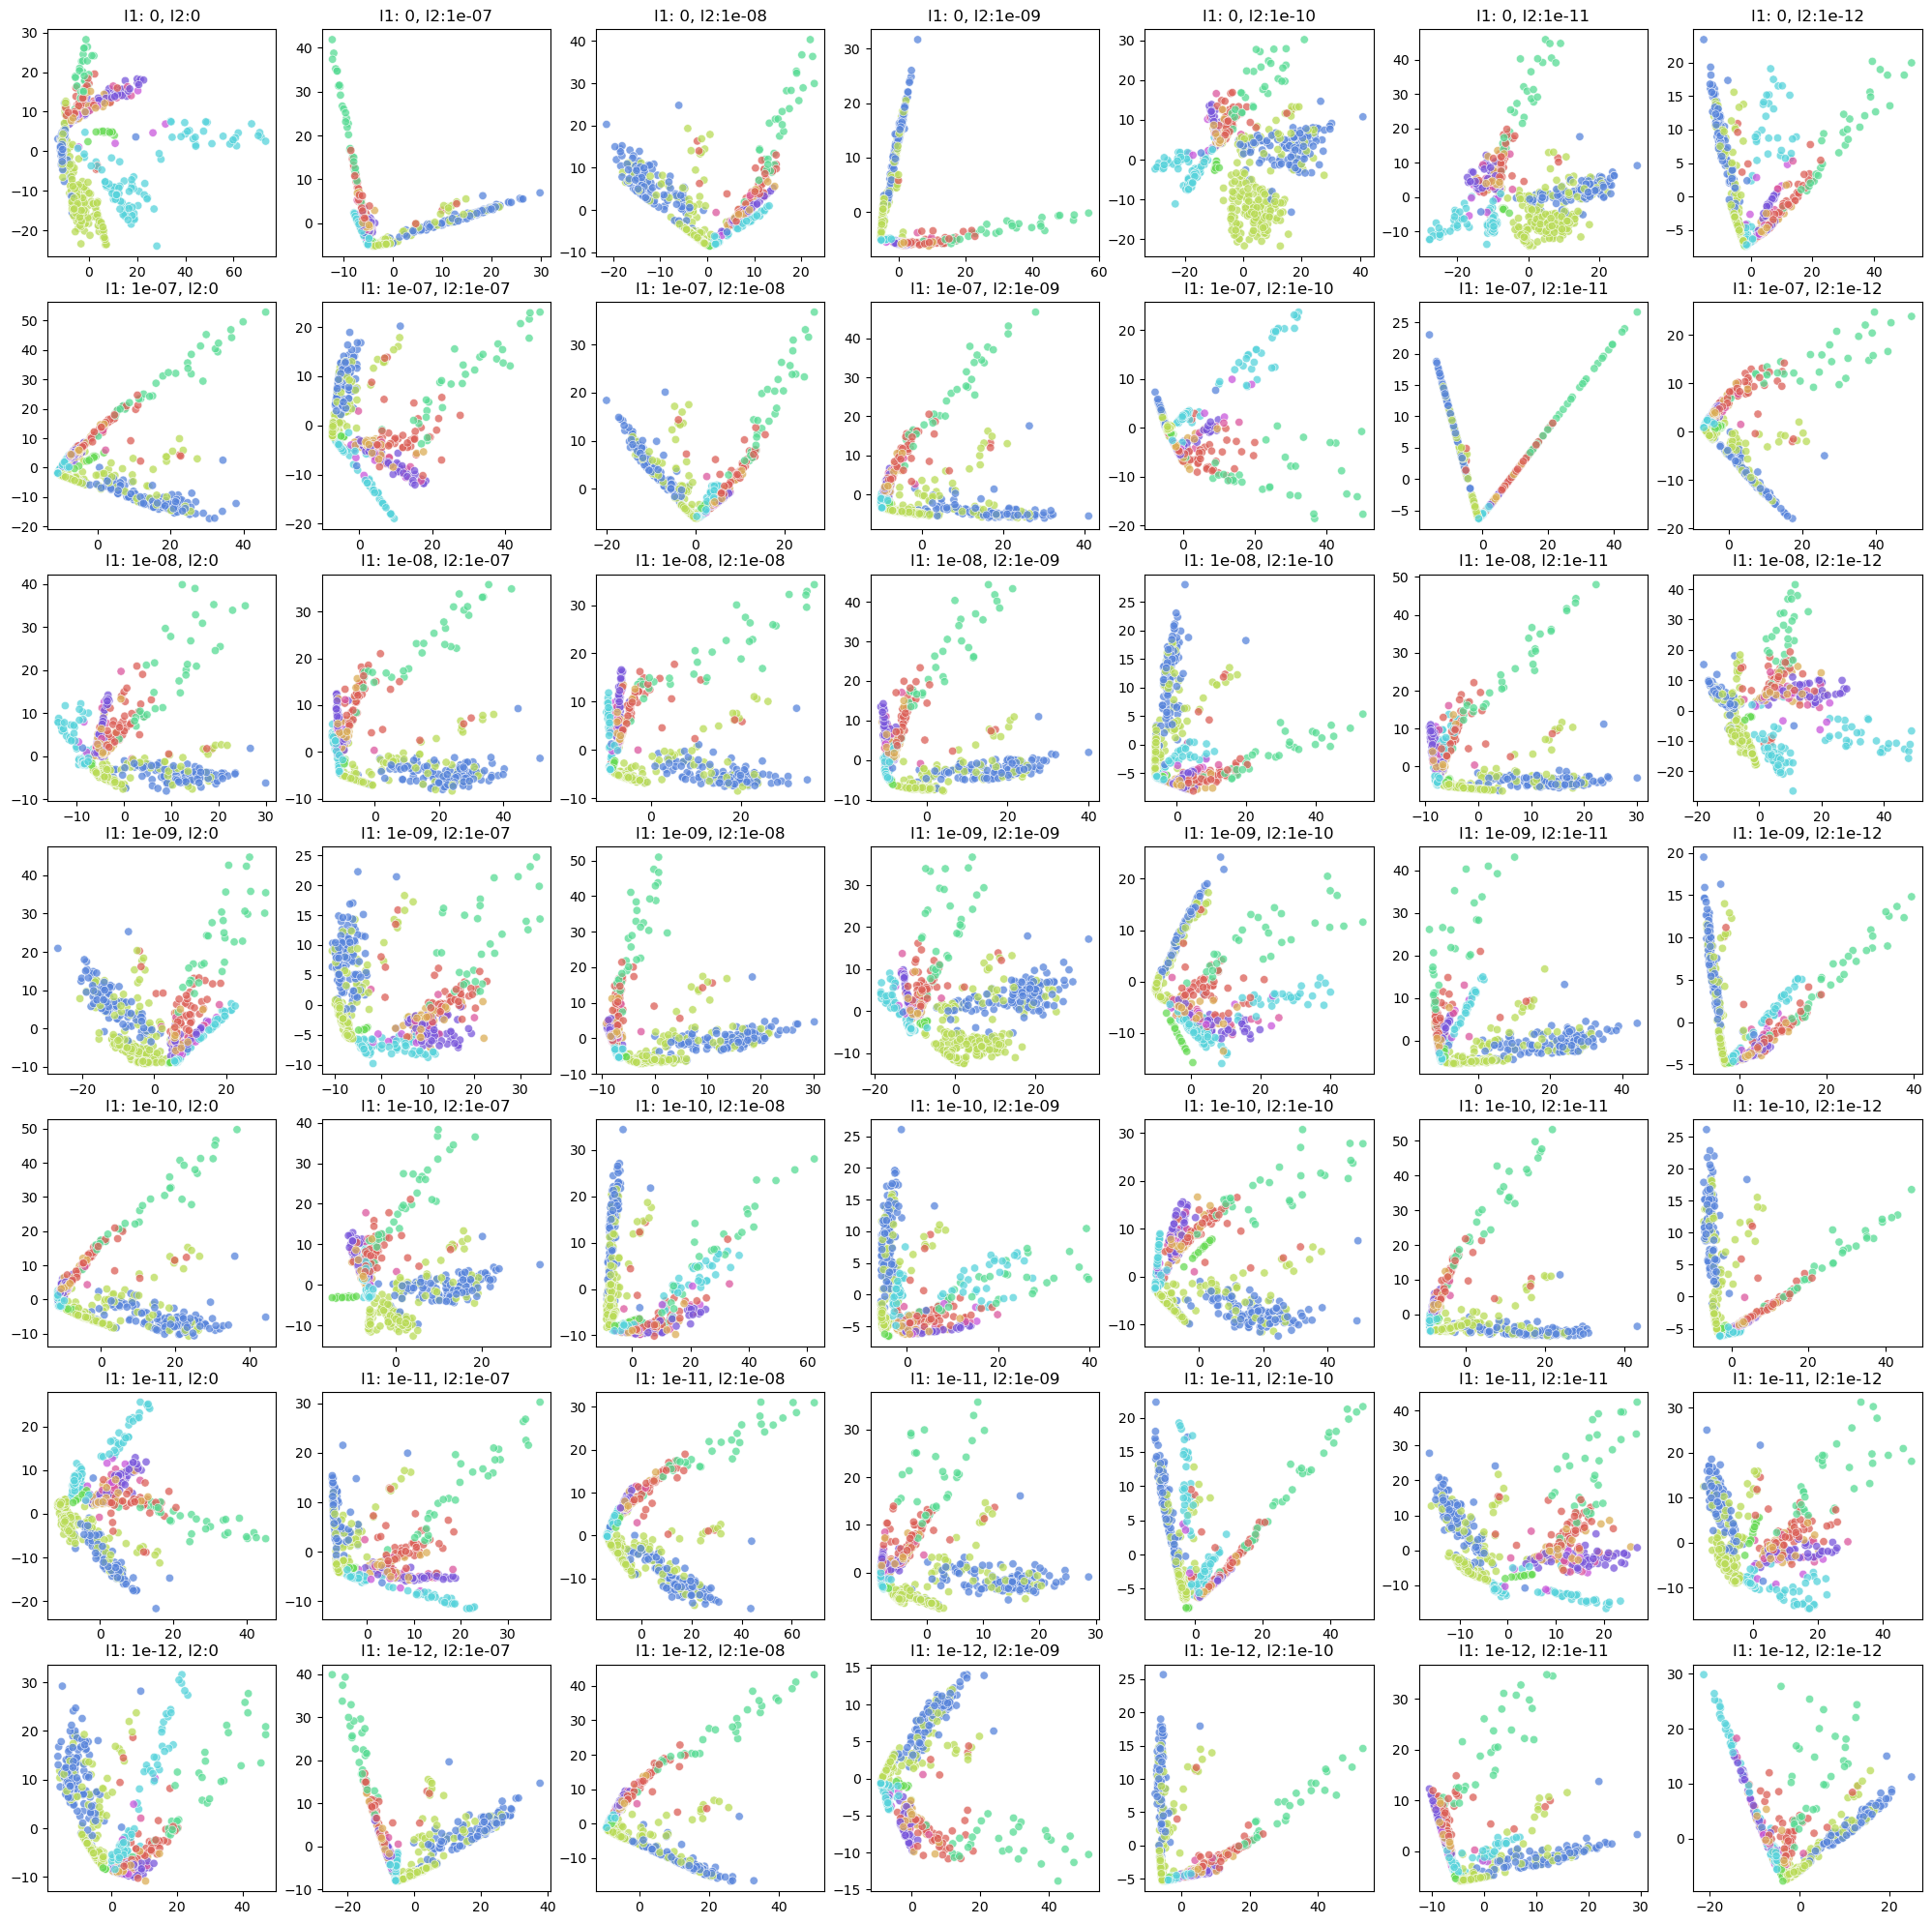

In [42]:
l1_list = power_list(7, 7)
l2_list = power_list(7, 7)
fig, axes = plt.subplots(7,7, figsize=(25,25))

#Save the model trained
dict_model = {l1: {l2: 0 for l2 in l2_list} for l1 in l1_list}

for i, l1 in enumerate(l1_list):
    for j, l2 in enumerate(l2_list):
        model = AutoEncoder([765, 512, 256, 128, 64, 32]) #[765, 382, 191, 95, 32]
        model = model.to(device)
        Trainer = AutoEncoderTrainer(model, batch_size=100, learning_rate=1e-3, epoch=30, l1=l1, l2=l2)
        _, _, model_trained = Trainer.train(X, X, draw_curve=False, early_stop=True)
        dict_model[l1][l2] = model_trained.state_dict()
        X_emb = model_trained.Encoder(X)
        X_emb = PCA(n_components=2).fit_transform(X_emb.detach().cpu().numpy())
        plot2D(X_emb, y, axes[i][j], f"l1: {l1}, l2:{l2}")
plt.show()

Based on this plot, the best configurations looks to be: 

|       |      |           |       |       |       |       |       |        |       |
|-------|------|-----------|-------|-------|-------|-------|-------|--------|-------|
|**l1** |  0   | 0         | 1e-7  | 1e-8  | 1e-9  | 1e-9  | 1e-10 | 1e-11  | 1e-11 |
|**l2** | 1e-10|  1e-11    | 1e-7  | 1e-12 | 1e-7  | 1e-9  | 1e-07 | 0      | 1e-11 |

Let's plot them in bigger to decide which **l1**, **l2** penalty should be used 

**Warning** AutoEncoder is not deterministic and may provide very different clustering every time. This the reason why once the model were trained, they were saved into ```dict_model```.

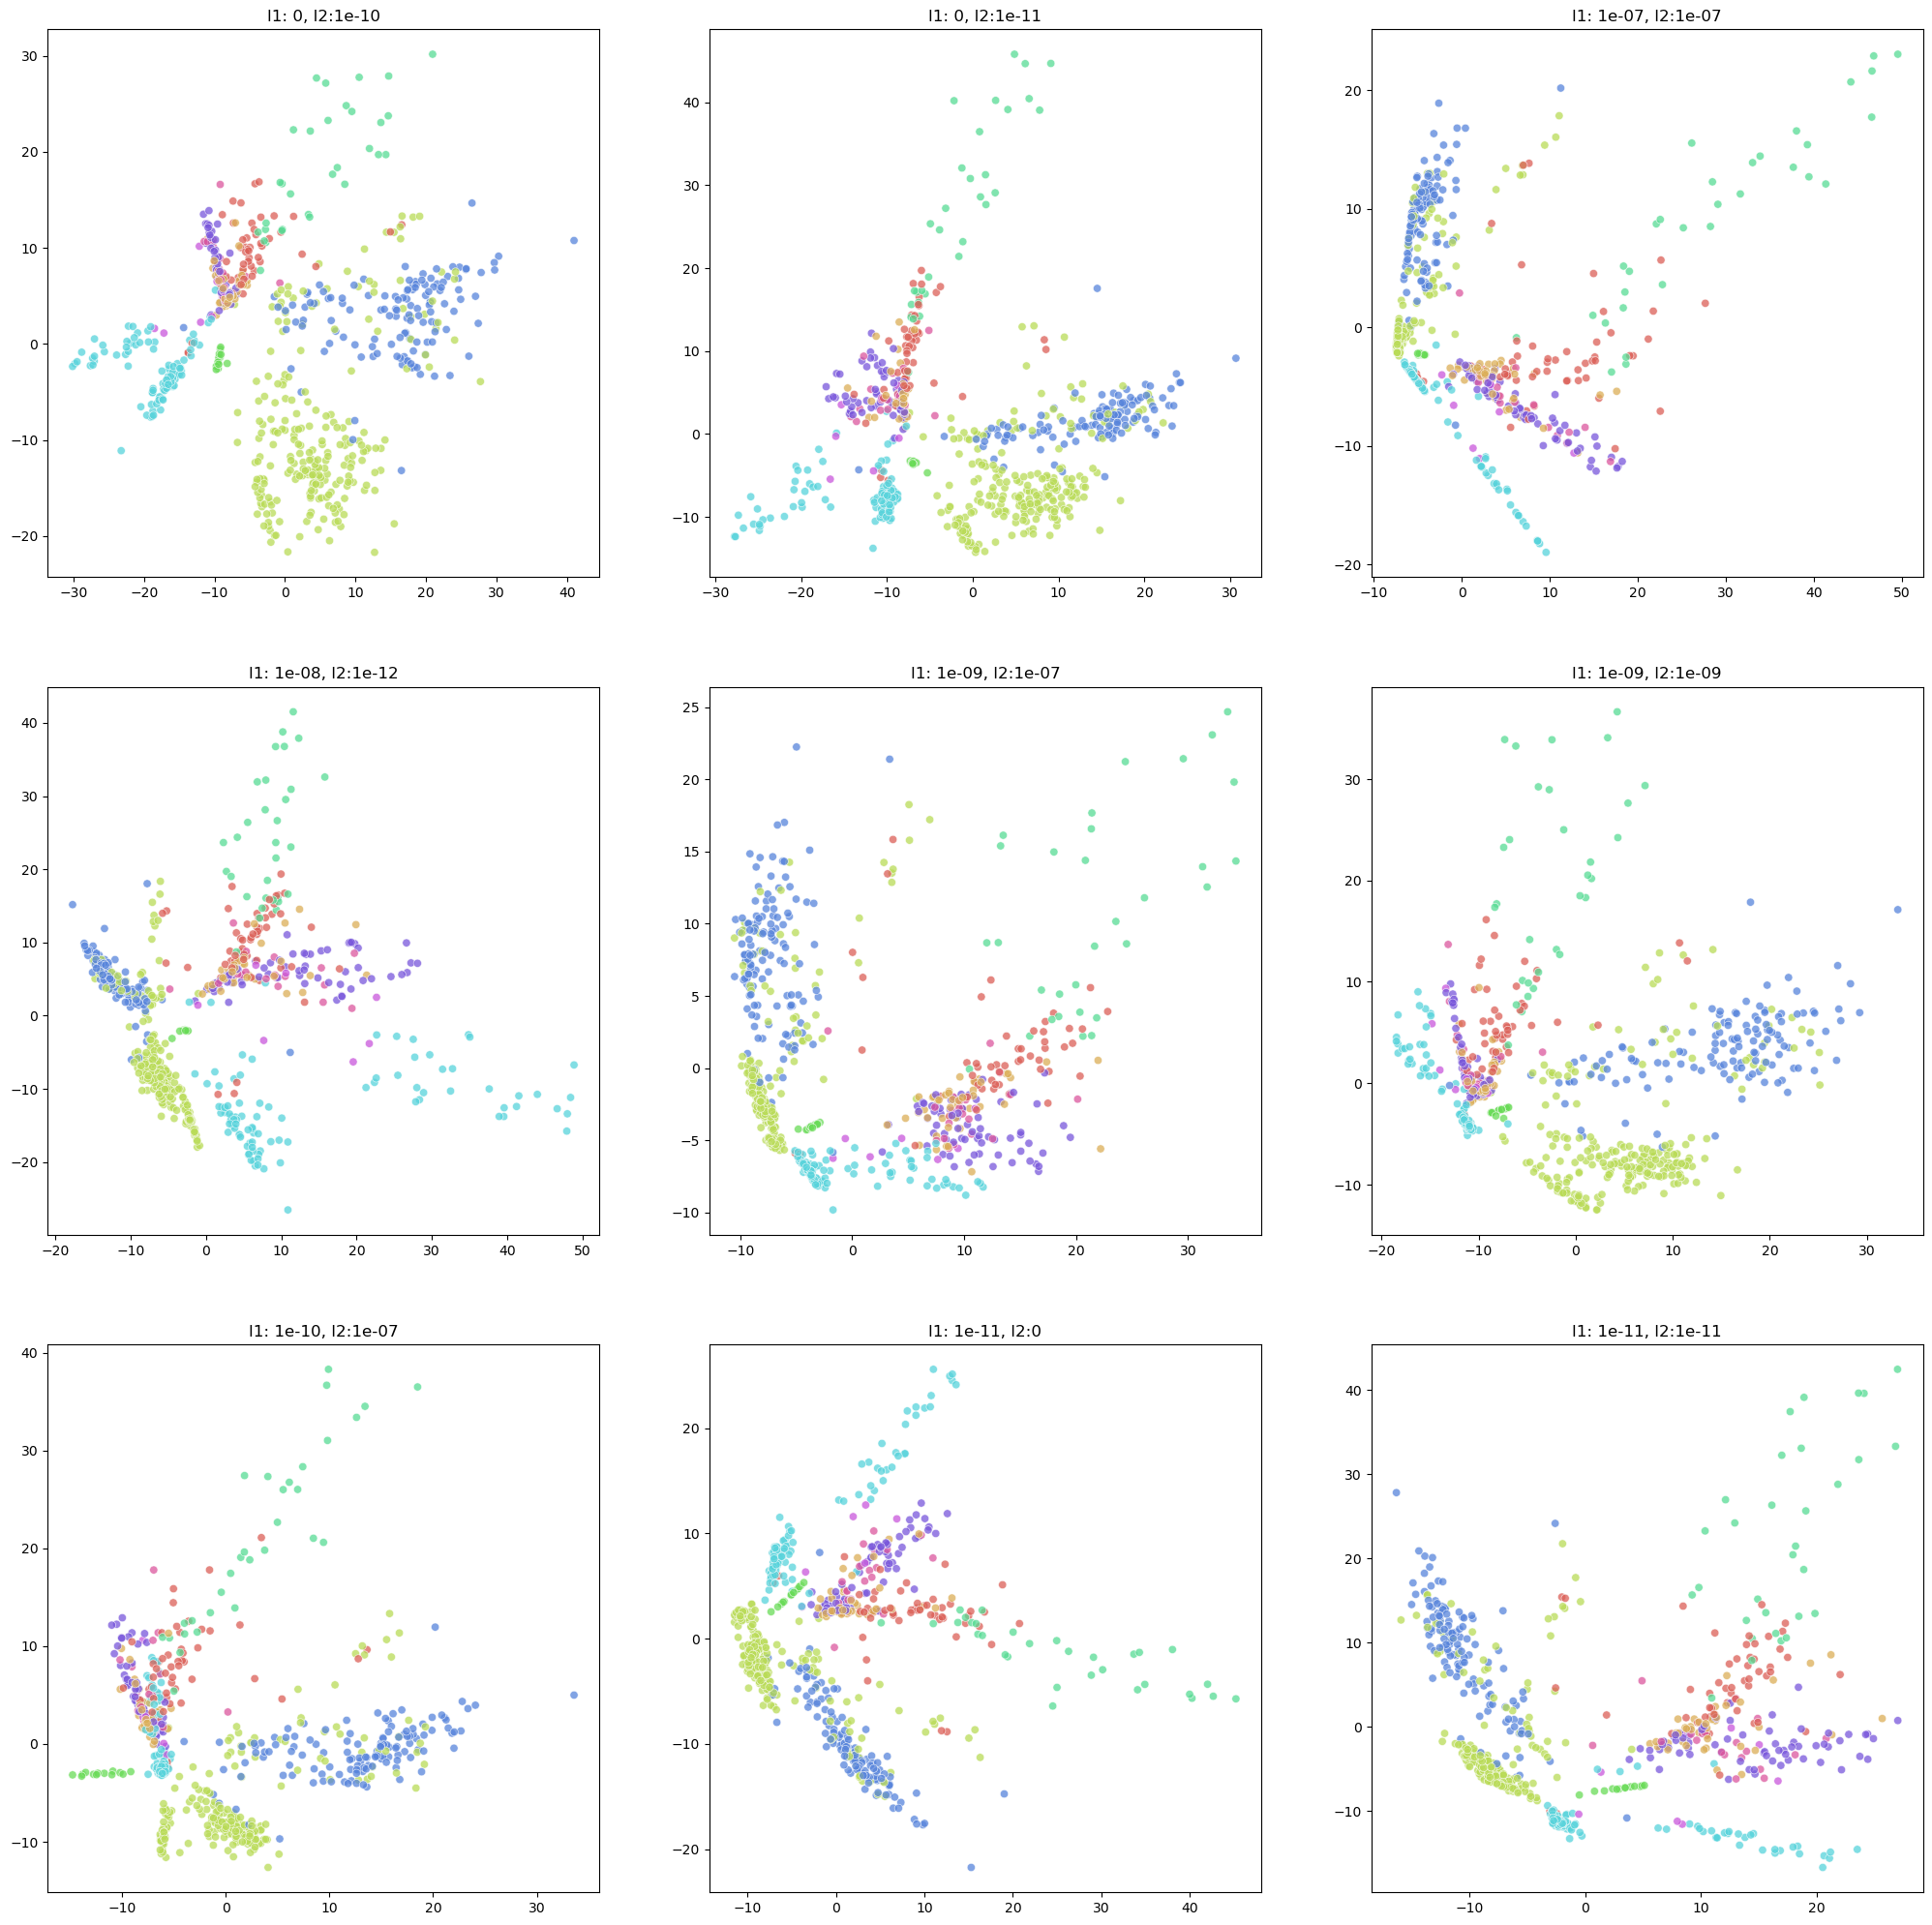

In [48]:
l1_list = [0 , 0, 1e-7, 1e-8, 1e-9, 1e-9, 1e-10, 1e-11, 1e-11]
l2_list = [1e-10, 1e-11, 1e-7, 1e-12, 1e-7, 1e-9, 1e-07, 0, 1e-11]
fig, axes = plt.subplots(3,3, figsize=(25,25))
axes = axes.flatten()
for i, (l1, l2) in enumerate(zip(l1_list, l2_list)):
    model = AutoEncoder([765, 512, 256, 128, 64, 32])
    model.load_state_dict(dict_model[l1][l2])
    model.to(device)
    X_emb = model.Encoder(X)
    X_emb = PCA(n_components=2).fit_transform(X_emb.detach().cpu().numpy())
    plot2D(X_emb, y, axes[i], f"l1: {l1}, l2:{l2}")
plt.show()

All of the solution proposed are pretty good in term of clustering. For each penalty, some class seems very difficult to separate. Without a clear measure of the clustering efficiency, the penalty **l1 = 1e-11** and **l2 = 0** looks slightly better (that may be subjective) and will be the one chosen to compare with PCA only and tSNE only. 

## B) Method Comparison <a id="Comparison"></a>

**Project Recquirement**

Use PCA and t-SNE on the dataset.

Then use PCA on the latent space representation of the dataset.

Plot all of these.

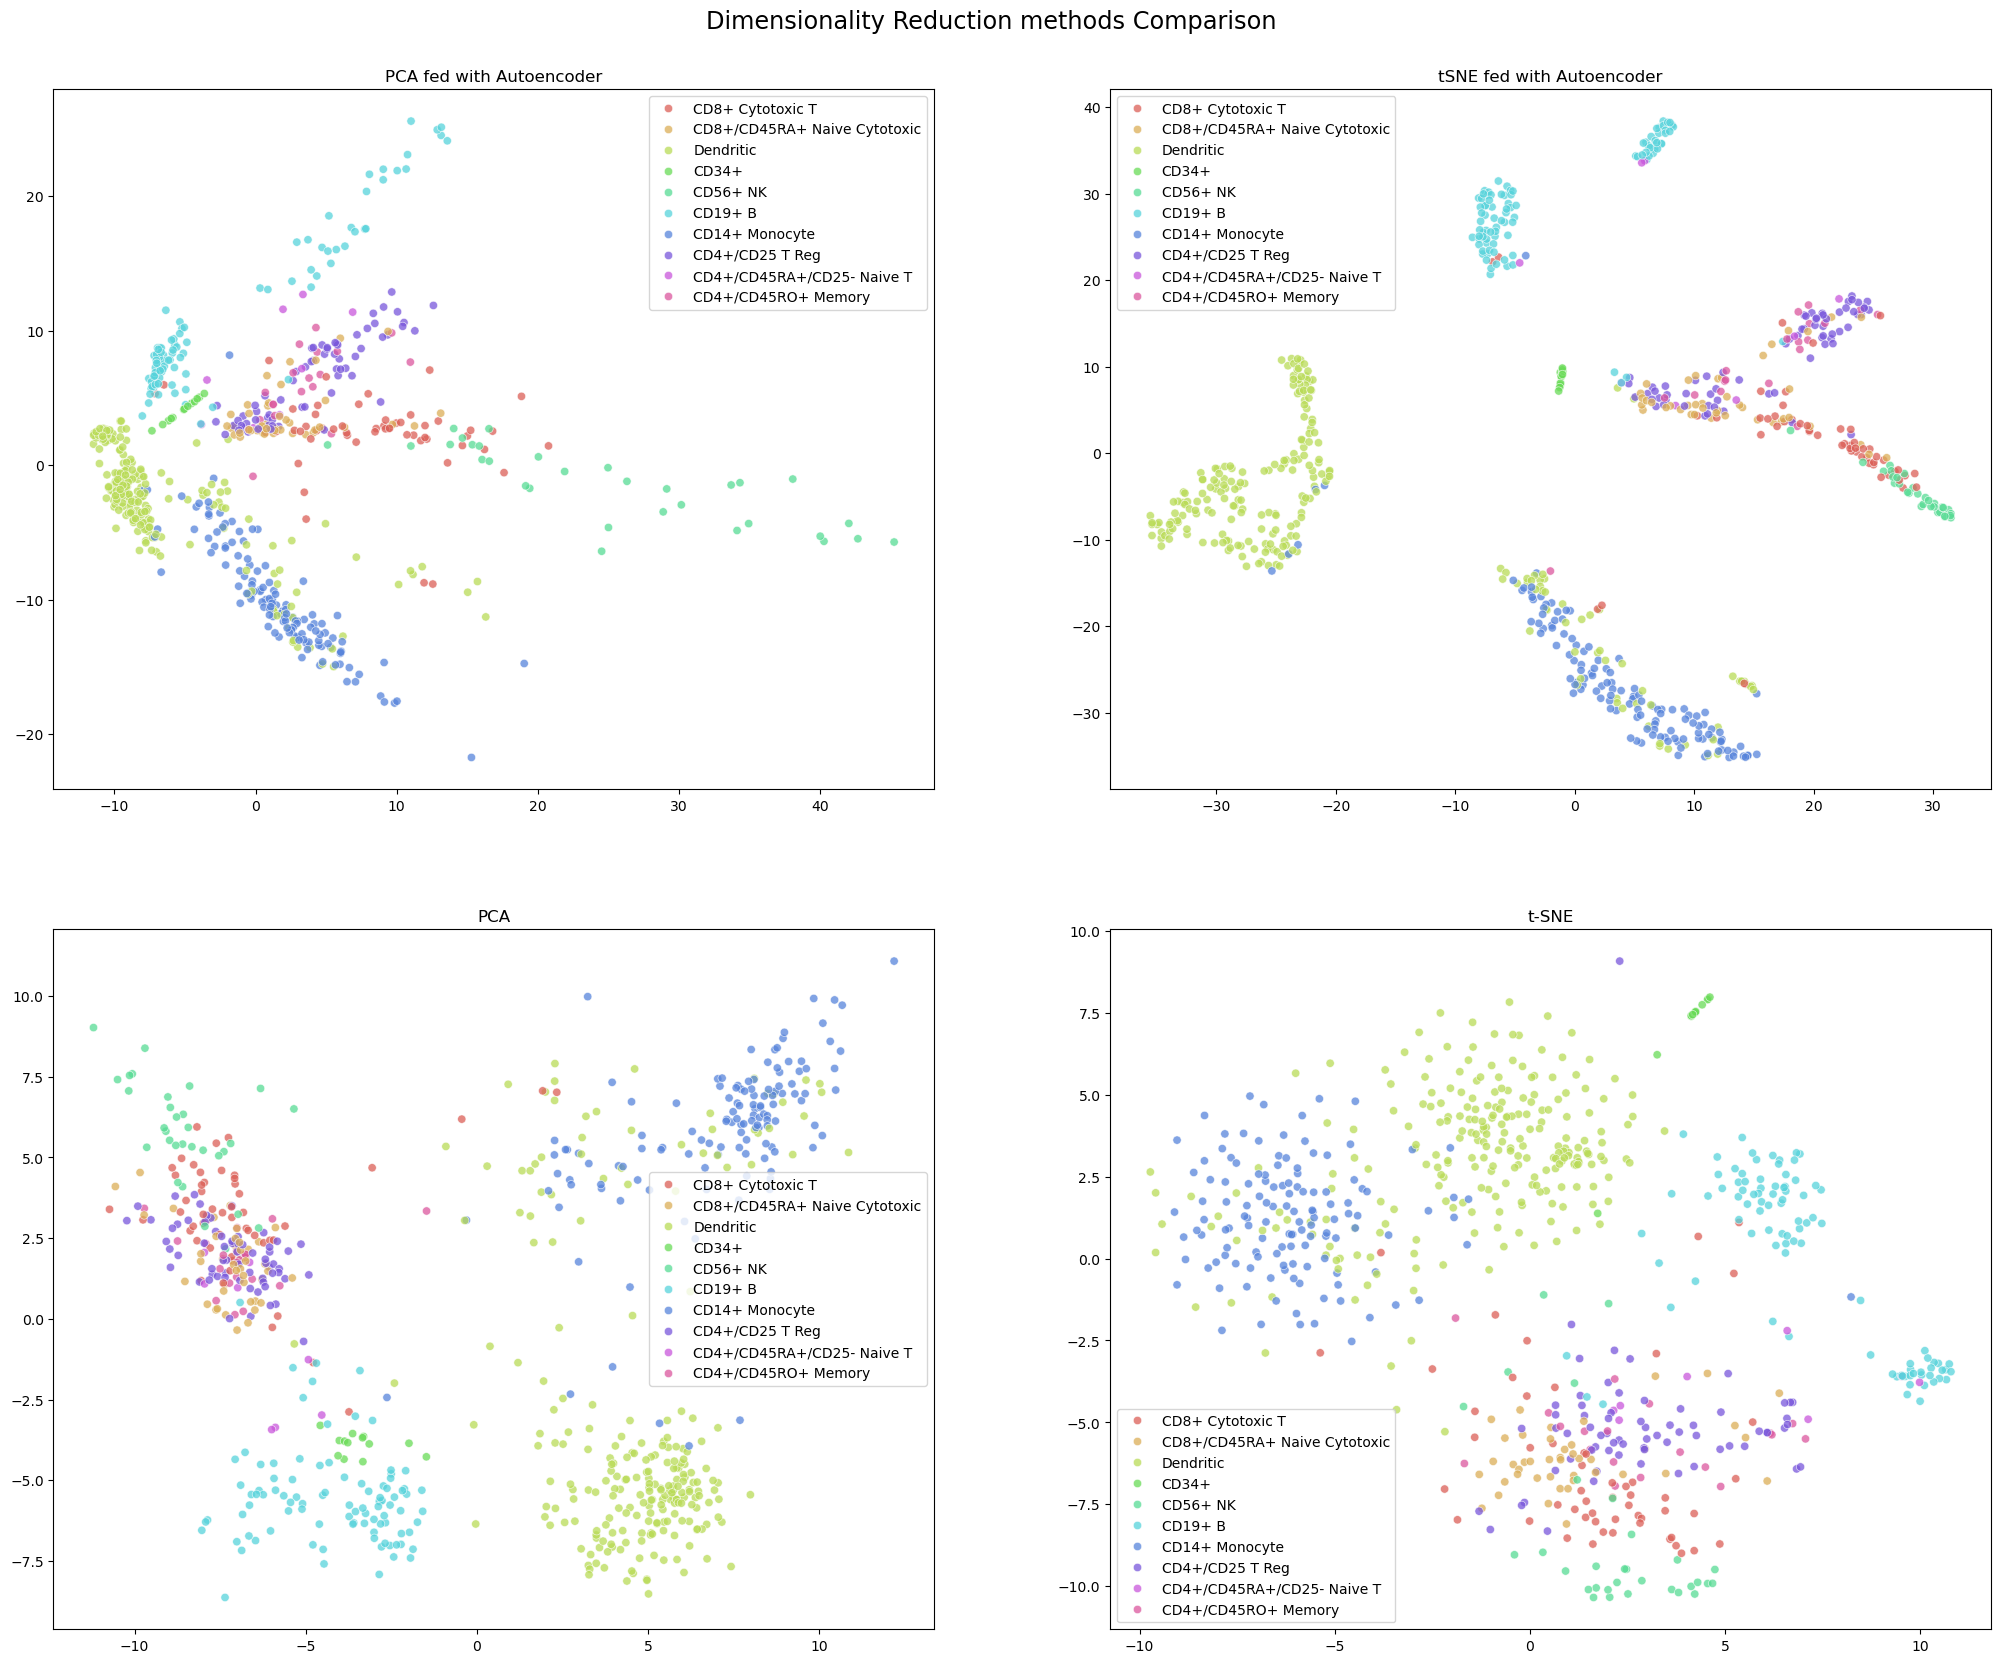

In [97]:
X_pca = PCA(n_components=2).fit_transform(X.detach().cpu().numpy())
X_tsne = TSNE(n_components=2).fit_transform(X.detach().cpu().numpy())

model = AutoEncoder([765, 512, 256, 128, 64, 32]) #[765, 382, 191, 95, 32]
model.load_state_dict(dict_model[1e-11][0])
model.to(device)

X_emb = model.Encoder(X)
X_emb_PCA = PCA(n_components=2).fit_transform(X_emb.detach().cpu().numpy())
X_emb_tSNE = TSNE(n_components=2).fit_transform(X_emb.detach().cpu().numpy())

fig, axes = plt.subplots(2,2, figsize=(25,20))
axes = axes.flatten()
title_L = ["PCA fed with Autoencoder", "tSNE fed with Autoencoder", "PCA", "t-SNE"]
X_list = [X_emb_PCA, X_emb_tSNE, X_pca, X_tsne]
for i in range(4):
    plot2D(X_list[i], y, axes[i], title_L[i], legend=True)

fig.suptitle("Dimensionality Reduction methods Comparison", y=0.92, fontsize="xx-large")
plt.show()

The preferred method will be discussed in **Conclusion**.

It can clearly be noticed that every cells classified as CD4... or CD8... are very similar and will be difficult to be classify. Let's quantify the amount of precision expected for a classifier. 

In [58]:
labels_pd.groupby("bulk_labels").size() * 100 / labels_pd.shape[0]

bulk_labels
CD14+ Monocyte                  18.428571
CD19+ B                         13.571429
CD34+                            1.857143
CD4+/CD25 T Reg                  9.714286
CD4+/CD45RA+/CD25- Naive T       1.142857
CD4+/CD45RO+ Memory              2.714286
CD56+ NK                         4.428571
CD8+ Cytotoxic T                 7.714286
CD8+/CD45RA+ Naive Cytotoxic     6.142857
Dendritic                       34.285714
dtype: float64

In [85]:
CD4_CD8 = labels_pd.iloc[:,1].unique()[pd.Series(labels_pd.iloc[:,1].unique()).str.startswith(('CD4', 'CD8'))]
(labels_pd.groupby("bulk_labels").size() * 100 / labels_pd.shape[0])[CD4_CD8].sum()

27.428571428571427

27% is the amount we are not sure to be able to properly classify. let's say that a dummy classifier associate all CD4..., CD8... to the CD4+/CD25 T Reg class. 

Therefore the amount of precision would be:

In [99]:
CD4_CD8 = labels_pd.iloc[:,1].unique()[pd.Series(labels_pd.iloc[:,1].unique()).str.startswith(('CD4+/CD45', 'CD8'))]
100 - (labels_pd.groupby("bulk_labels").size() * 100 / labels_pd.shape[0])[CD4_CD8].sum()

82.28571428571428

For the Part 2 of the project, this explain why the minimum accuracy expected is 80%. 

In [100]:
torch.save(model.state_dict(), "./Trained_AutoEncoder")

# 4) Conclusion <a id="Conclusion"></a>

When comparing the result of each techniques, several conclusion can be made:
+ **None of the plot are essentially better** than the other. Indeed, none of them give a clear separation for each class.  
+ Both **PCA and tSNE has the interest to give a very deterministic response**. While the AutoEncoder may have to be run several times with the exact same parameter before to reach a descent clustering. 
+ Looking at **PCA or tSNE fed with autoencoder, both of them give tighter cluster than PCA and tSNE only** and ultimately a better separation of each class.
+ tSNE is the plot which gives the worse cluster in term of density. The reason is that tSNE is known to perform bad when feed with a large number of features. A better practice is to feed it with PCA or with autoencoder as before. 

The question remain, which technique to choose. My answer will depend on what is the purpose.  
+ For **Unsupervised Learning**: 
    - Here a clustering algorithm will be used. The more separate the cluster are, the better. I would therefore go for PCA or tSNE fed with autoencoder.
    - In particular, for an algorithm such as a **Gaussian mixture model**, I would prefer the **PCA fed with autoencoder** as the **cluster are more elliptic**. 
    - For an algorithm such as **DBSCAN**, which is based on the **cluster density**, I would prefer **tSNE fed with autoencoder** as it would reduce the number of cells classified as outliers.
    
+ For **Dimension reduction for Supervised Learning**: 
    - Using **PCA provide a systematic method to apply to all data set**. The consistency of PCA is preferable over the autoencoder as it response may vary a lot. And tSNE should not be used as it doesn't perform well on large amount of input feature. 
    - However, in the context of supervised learning, there is no need to create an autoencoder, to reduce the dimension input and then classify using a Feed Forward Neural Network (FFNN). The process is repetitive, and a classic FFNN reducting directly the input feature data to a class prediction is preferable as the model tuning will be directly quantify in term of accuracy performance, rather than having to tune both an autoencoder and a FFNN. 
    
Thank you for reading! 